In [26]:
import statsmodels.formula.api as sm
import warnings; warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt; plt.rcParams["figure.figsize"] = (20,10)
import numpy as np
import seaborn as sns
from scipy import stats
from rdrobust import rdrobust, rdplot, rdbwselect

## Question 5

### A

#### Creating the income_centered variable from a hypothetical income_predicted variable

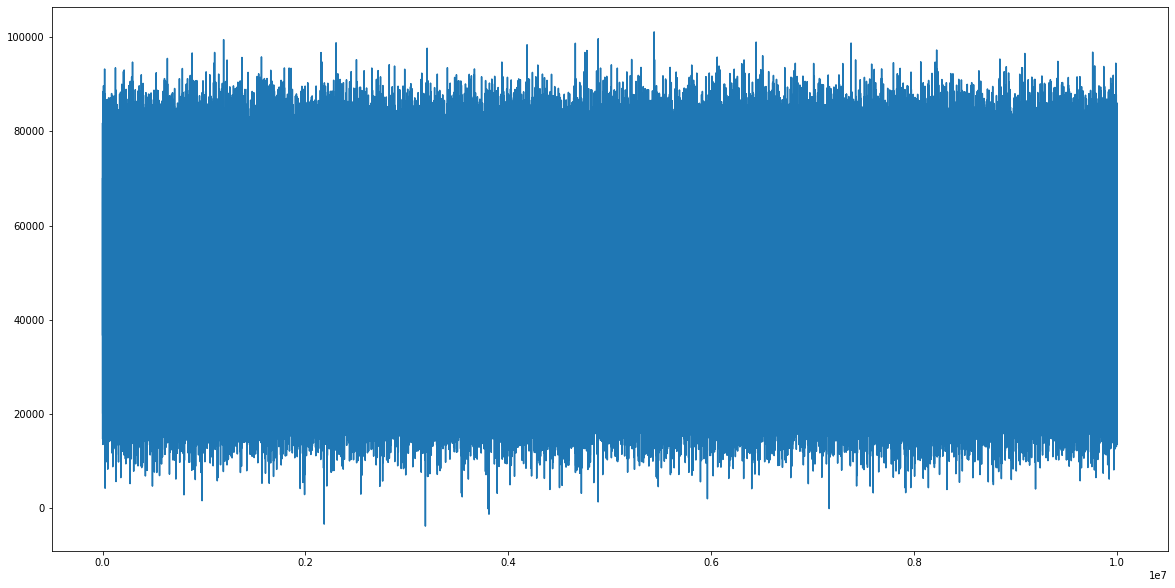

In [15]:
# Random guassian distribution of incomes, mean of $50k, std 0f $10k
fake_income_distribution = np.random.normal(50000, 10000, 10000000)
plt.plot(fake_income_distribution);

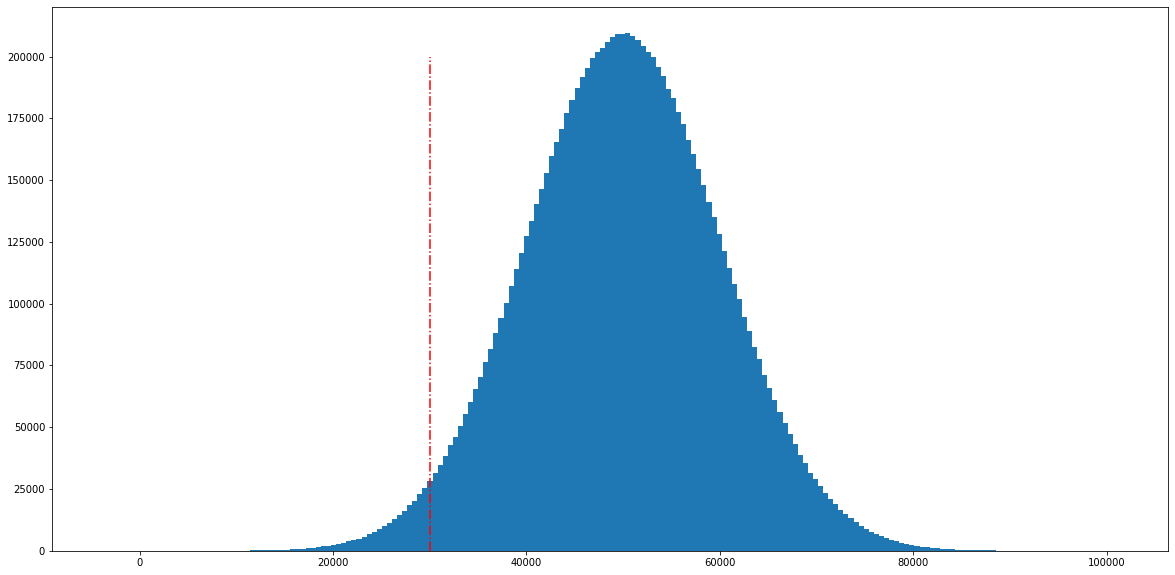

In [16]:
# Histogram of income with cutoff of $30k
income_cutoff = 30000
plt.hist(fake_income_distribution, bins = 200);
plt.vlines(income_cutoff, 0, 200000, color = 'red', linestyles='dashdot');

In [17]:
# Creating a dataframe with income (in thousands USD)
data = pd.DataFrame()
income_cutoff = income_cutoff / 1000

# Creating faux income_predicted variable from synthetic distribution
data['income_predicted'] = fake_income_distribution / 1000

# Creating income_centered vairable
data['income_centered'] =  data['income_predicted'] - income_cutoff

# Slicing the data to only include form -0.02 to 0.02
data = data[abs(data.income_centered) <= 0.02 ]

# How many observations within 
len(data)

2104

### B

#### Replicating the original graph

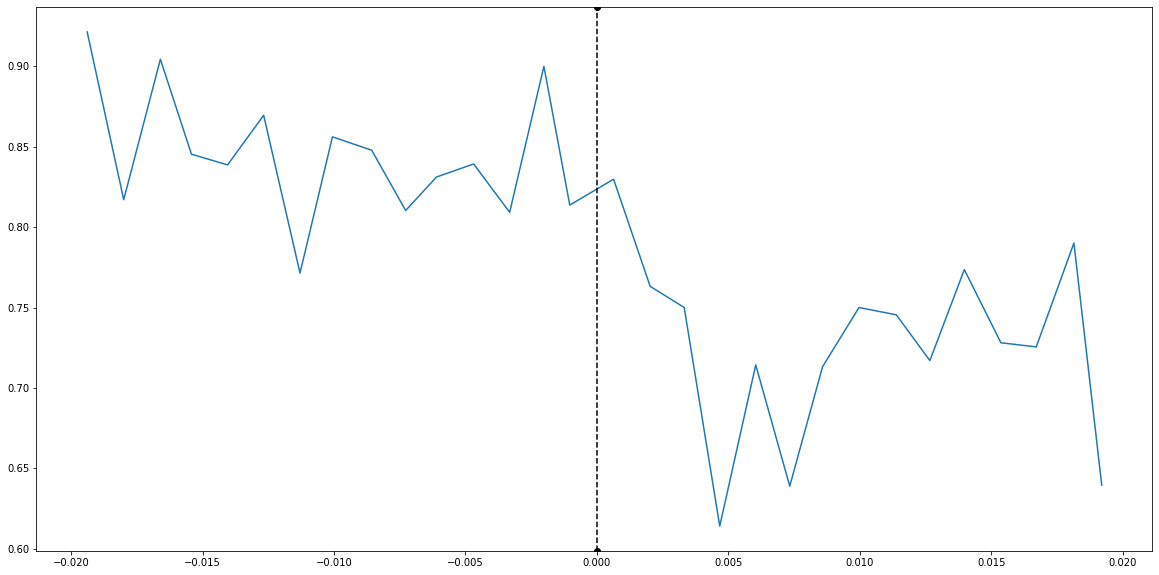

In [18]:
df = pd.read_stata('./data/gov_transfers.dta')

# cut at 0, and 15 places on either side
edges = np.linspace(-.02,.02,31)
df['bins'] = pd.cut(df['income_centered'], bins = edges)

# Aggregate function does not work - manually creating aggregates
income_means = []
support_means = []
for bin in sorted(df.bins.unique()):
    d = df[df.bins == bin].reset_index(drop=True)
    income_means.append(d['income_centered'].mean())
    support_means.append(d['support'].mean())

plt.plot(income_means,support_means);
plt.axvline(0, 0, 1, linestyle='dashed', marker='o', color = 'black');

#### Changing the bandwidth to 0.01

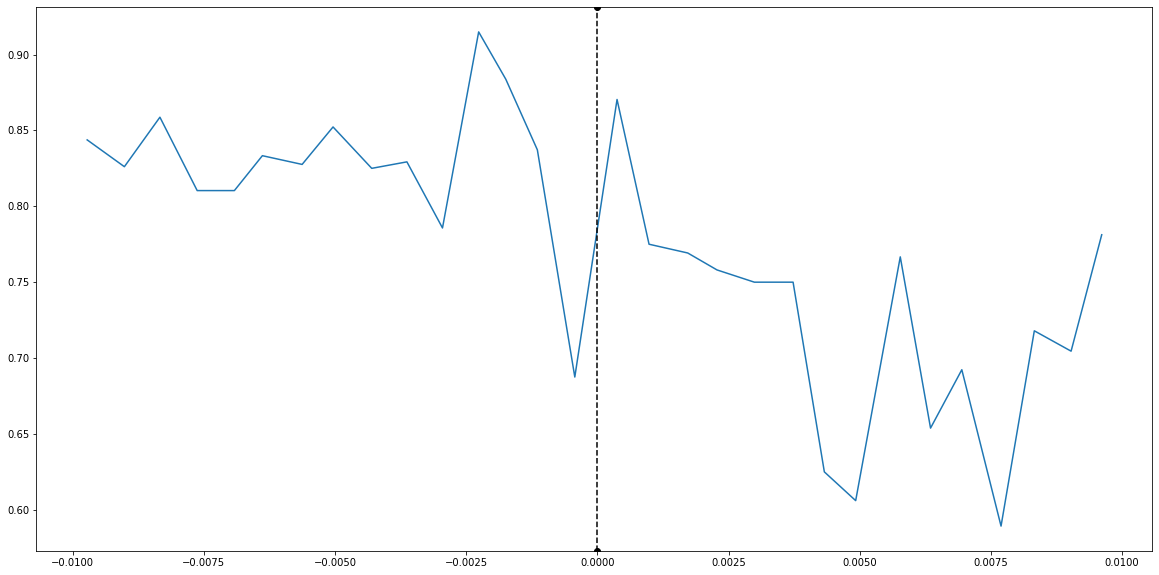

In [19]:
df = pd.read_stata('./data/gov_transfers.dta')

# cut at 0, and 15 places on either side
edges = np.linspace(-.01,.01,31)
df['bins'] = pd.cut(df['income_centered'], bins = edges)

df.sort_values('bins', inplace=True)

# Aggregate function does not work - manually creating aggregates
income_means = []
support_means = []
bins = []
for bin in df.bins.unique():
    d = df[df.bins == bin].reset_index(drop=True)
    income_means.append(d['income_centered'].mean())
    support_means.append(d['support'].mean())

plt.plot(income_means,support_means);
plt.axvline(0, 0, 1, linestyle='dashed', marker='o', color = 'black');

##### Changing the bandwidth from 0.02 to 0.01, while plotting the same data, seems to cast a bit of doubt on the trend prior and post of the cutoff. There is a lot of noise around the cutoff.

### C

In [20]:
''' Basic Export to File -- Nothing to see here'''

def export_results_to_csv(summary, filename, directory = './Assignment_4_Files/'):
    for i in np.arange(len(summary.tables)):
        df = pd.DataFrame(summary.tables[i])
        if i == 0:
            type = 'results'
        if i == 1:
            type = 'coefficients'
        if i == 2:
            type = 'info'
        df.to_csv(directory + filename + '_' + type +'.csv')

#### Uniform Kernal, Quadratic Polynomial, 0.01 Bandwidth

In [21]:
# Creating temporary dataframe with a cutoff of 0.01
df1 = df[abs(df.income_centered) < 0.01]

# Run the polynomial model
m1 = sm.ols('support~ income_centered * participation + (income_centered**2) * participation', data = df1).fit()
export_results_to_csv(m1.summary(), 'q5c_m1', directory = './Assignment_5_Files/')
print('m1 summary:',m1.summary())


m1 summary:                             OLS Regression Results                            
Dep. Variable:                support   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     12.10
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           8.91e-08
Time:                        16:15:45   Log-Likelihood:                -261.97
No. Observations:                 937   AIC:                             531.9
Df Residuals:                     933   BIC:                             551.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

#### Triangle Kernal, Quadratic Polynomial, 0.02 Bandwidth 

In [22]:
# Create the kernel function
def kernel(x):
    w = 1 - 50*np.abs(x) # -1/0.02 = 50
    w = np.maximum(0,w)
    return w

# Run the linear model with weights using wls
m2 = sm.wls('support ~ income_centered * participation + (income_centered**2) * participation', data = df, weights = kernel(df['income_centered'])).fit()
export_results_to_csv(m1.summary(), 'q5c_m2', directory = './Assignment_5_Files/')
print('m2 summary:',m2.summary())

m2 summary:                             WLS Regression Results                            
Dep. Variable:                support   R-squared:                       0.030
Model:                            WLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     20.34
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           5.63e-13
Time:                        16:15:45   Log-Likelihood:                -805.76
No. Observations:                1948   AIC:                             1620.
Df Residuals:                    1944   BIC:                             1642.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

### D

#### Setting our X and Y Variables From Data 

In [23]:
df = pd.read_stata('./data/gov_transfers.dta')
df['participation'] = df['participation'].apply(lambda x: 1 if x == 'Got a transfer' else 0).astype('int64')
y = df['support']
x = df['income_centered']

#### Implementing the rdrobust package with Uniform Kernal, Quadratic Polynomial, mserd Bandwidth  Selection'

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


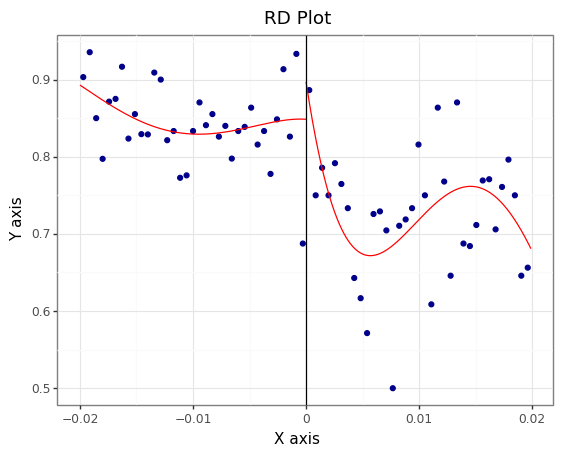


Call: rdplot
Number of Observations:                  1948
Kernel:                               Uniform
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations          1127        821
Number of Effective Obs         1127        821
Bandwith poly. fit (h)          0.02       0.02
Number of bins scale               1          1
Bins Selected                     35         35
Average Bin Length             0.001      0.001
Median Bin Length              0.001      0.001
IMSE-optimal bins                3.0        7.0
Mimicking Variance bins         35.0       35.0

Relative to IMSE-optimal:
Implied scale                 11.667        5.0
WIMSE variance weight          0.001      0.008
WIMSE bias weight              0.999      0.992


In [24]:
rd1 = rdrobust(y=y, x=x, 
                fuzzy = None, deriv = None, c = None,
                p = 2, q = None, h = None, b = None, rho = None, 
                covs = None, covs_drop = True,
                kernel = "uni", weights = None, bwselect = "mserd", #<-------- automatic banwidth selection option
                vce = "nn", cluster = None, nnmatch = 3, level = 95, 
                scalepar = 1, scaleregul = 1, sharpbw = False, 
                all = None, subset = None, masspoints = "adjust",
                bwcheck = None, bwrestrict = True, stdvars = False)

rdplot(y = y, x = x, 
       c = 0, p = 4, nbins = None, binselect = "esmv", scale = None, 
       kernel = "uni", weights = None, h = None, 
       covs = None,  covs_eval = "mean", covs_drop = True,
       support = None, subset = None, masspoints = "adjust",
       hide = False, ci = None, shade = False, 
       title = None, x_label = None, y_label = None, x_lim = None,
       y_lim = None, col_dots = None, col_lines = None)

#### Implementing the rdrobust package with Triangle Kernal, Quadratic Polynomial, mserd Bandwidth  Selection'

Mass points detected in the running variable.
Mass points detected in the running variable.
Mass points detected in the running variable.


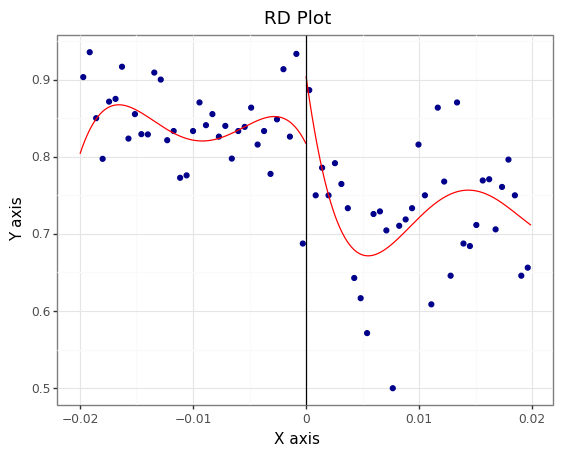


Call: rdplot
Number of Observations:                  1948
Kernel:                            Triangular
Polynomial Order Est. (p):                  4

                                Left      Right
------------------------------------------------
Number of Observations          1127        821
Number of Effective Obs         1126        820
Bandwith poly. fit (h)          0.02       0.02
Number of bins scale               1          1
Bins Selected                     35         35
Average Bin Length             0.001      0.001
Median Bin Length              0.001      0.001
IMSE-optimal bins                3.0        7.0
Mimicking Variance bins         35.0       35.0

Relative to IMSE-optimal:
Implied scale                 11.667        5.0
WIMSE variance weight          0.001      0.008
WIMSE bias weight              0.999      0.992


In [25]:
rd2 = rdrobust(y=y, x=x, 
                fuzzy = None, deriv = None, c = None,
                p = 2, q = None, h = None, b = None, rho = None, 
                covs = None, covs_drop = True,
                kernel = "tri", #<-------- triangle kernal option
                weights = None, bwselect = "mserd", #<-------- automatic banwidth selection option
                vce = "nn", cluster = None, nnmatch = 3, level = 95, 
                scalepar = 1, scaleregul = 1, sharpbw = False, 
                all = None, subset = None, masspoints = "adjust",
                bwcheck = None, bwrestrict = True, stdvars = False)
rdplot(y = y, x = x, 
       c = 0, p = 4, nbins = None, binselect = "esmv", scale = None, 
       kernel = "tri", weights = None, h = None, 
       covs = None,  covs_eval = "mean", covs_drop = True,
       support = None, subset = None, masspoints = "adjust",
       hide = False, ci = None, shade = False, 
       title = None, x_label = None, y_label = None, x_lim = None,
       y_lim = None, col_dots = None, col_lines = None)